## Task Tntroduction
here the we extend task1 by add the complexity of the model inculde:<br>
1:use the deep RNN net work <br>
2:use LSTM as a better neuron to remmeber the words around the word<br>
3:using wordvec to better represent the word<br>
4:optimizer and regex

In [46]:
import torch
import torch.nn as nn
from torchtext.legacy import data

SEED = 12
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True)

LABEL = data.LabelField(dtype = torch.float)

In [47]:
from torchtext.legacy import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [48]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [50]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [51]:
#detect if gpu is avaliable
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#bulid data iterate
train_iterator , valid_iterator , test_iterator = data.BucketIterator.splits(
    (train_data , valid_data , test_data) , 
    batch_size = batch_size , 
    sort_within_batch = True , 
    device = device
)

In [62]:
import torch.nn as nn
'''class BLSTM(nn.Module):
    def __init__(self , vocab_size , embedding_dim , hidden_dim , output_dim , n_layers , 
                bidirectional , dropout , pad_idx):
        super().__init__()
        #define the embedding 
        self.embedding  = nn.Embedding(vocab_size , embedding_dim , padding_idx = pad_idx)
        
        #BLSTM
        self.rnn = nn.LSTM(embedding_dim ,#input size 
                           hidden_dim , #ouput size 
                           num_layers = n_layers , # number of layers
                           bidirectional = bidrectional , #whether bidrectional
                           dropout = dropout #regularization
                          )
        self.fc = nn.Linear(embedding_dim*2 , output_dim)
        self.dropout = nn.Dropout(dropout)
        def forward(self , text ,text_lengths):
            #shape of the text = [sen len  , batch size]
            embedding = self.dropout(self.embedding(text))
            #shape of the embedding = [sent len , batch size , emd dim]
            #pack len
            #lengths need cpu
            packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
            packed_output, (hidden, cell) = self.rnn(packed_embedded)

            #unpack sequence
            output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

            #output的形状[sent len, batch size, hid dim * num directions]
            #output中的 padding tokens是数值为0的张量

            #hidden 的形状 [num layers * num directions, batch size, hid dim]
            #cell 的形状 [num layers * num directions, batch size, hid dim]

            #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
            #and apply dropout

            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

            #hidden 的形状 [batch size, hid dim * num directions]

            return self.fc(hidden)'''
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        # embedding嵌入层（词向量）
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        # RNN变体——双向LSTM
        self.rnn = nn.LSTM(embedding_dim,  # input_size
                           hidden_dim,  #output_size
                           num_layers=n_layers,  # 层数
                           bidirectional=bidirectional, #是否双向
                           dropout=dropout) #随机去除神经元
        # 线性连接层
        self.fc = nn.Linear(hidden_dim * 2, output_dim) # 因为前向传播+后向传播有两个hidden sate,且合并在一起,所以乘以2
        
        # 随机去除神经元
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text 的形状 [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded 的形状 [sent len, batch size, emb dim]
        
        # pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output的形状[sent len, batch size, hid dim * num directions]
        #output中的 padding tokens是数值为0的张量
        
        #hidden 的形状 [num layers * num directions, batch size, hid dim]
        #cell 的形状 [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden 的形状 [batch size, hid dim * num directions]
            
        return self.fc(hidden)

In [63]:
INPUT_DIM = len(TEXT.vocab) # 250002: 之前设置的只取25000个最频繁的词,加上pad_token和unknown token
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
bidrectional = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] #指定参数,定义pad_token的index索引值,让模型不管pad token

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            bidrectional, 
            DROPOUT, 
            PAD_IDX)

In [61]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,810,545 trainable parameters


In [55]:
pretrained_embeddings = TEXT.vocab.vectors
# 检查词向量形状 [vocab size, embedding dim]
print(pretrained_embeddings.shape)

torch.Size([25002, 100])


In [56]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.4520,  0.2510, -0.5652,  ...,  0.2167, -0.6711, -0.0650],
        [ 0.8051, -0.3054, -0.7936,  ...,  0.2331, -0.2549,  1.9586],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.4871, -0.2781,  0.1880,  ..., -0.0326,  0.6076, -0.0916],
        [ 1.3776, -0.0094,  0.5243,  ..., -0.1088, -0.5908, -0.7924],
        [ 0.1494,  0.4153,  0.3634,  ..., -0.3618, -0.4710,  0.7414]])

In [57]:
#将unknown 和padding token设置为0
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.4871, -0.2781,  0.1880,  ..., -0.0326,  0.6076, -0.0916],
        [ 1.3776, -0.0094,  0.5243,  ..., -0.1088, -0.5908, -0.7924],
        [ 0.1494,  0.4153,  0.3634,  ..., -0.3618, -0.4710,  0.7414]])


In [58]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss() # 损失函数. criterion 在本task中时损失函数的意思

model = model.to(device)
criterion = criterion.to(device)

In [38]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [39]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad() # 梯度清零
        
        text, text_lengths = batch.text # batch.text返回的是一个元组(数字化的张量,每个句子的长度)  
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text  #batch.text返回的是一个元组(数字化的张量,每个句子的长度) 
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 2

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    # 保留最好的训练结果的那个模型参数，之后加载这个进行预测
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

## Conlution
task3 foce mainly on the lstm and wordvec <br>
here we use the standford glove vec and construct the model with lstm as the neuron<br>
here are thing about structure of the model i wanna talk about!<br>
1:everything would look like the same as the last model, instead we add lstm and wordvec so the text <br>
firstly go to the embedding and transfor as a vector , then all of those vector as a whole go to the lstm one neuron by on neuron. we double the linear input size beacuse it was bidrectional lstm model!
2:we use adam optimizer as a tool to train the model faster

## something i don't get it！
1:the structure of the data
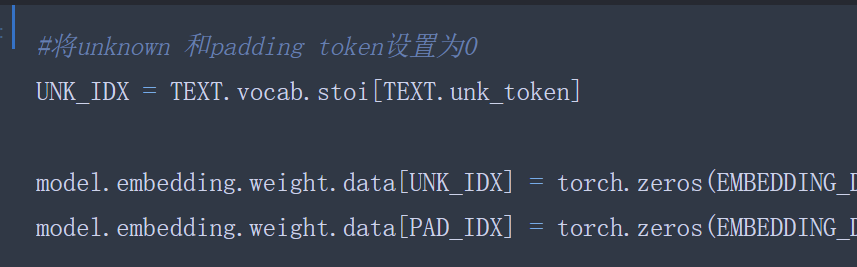
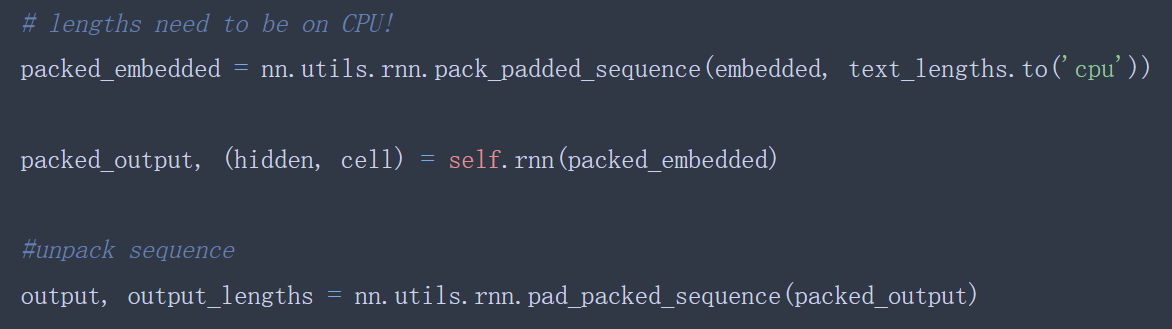